In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import geopandas

%matplotlib inline

##  The Novel Coronavirus: Data Science and Machine Learning Visualizations

This is the site where I pull the recent `.csv` files: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

Formats of the `.csv` files are bound to change and they're manually pulled from the website.

Also trying to find ways to automatically pull the dataset, if possible

In [2]:
!ls

COVID19 Visualizations.ipynb README.md
COVID19_databases            cases_country
COVID19_worldwide.png        cases_country_active
COVID19_worldwideACTIVE.png  cases_country_individual
Icon?                        geo


Load the CSV files. Please make sure to pull the latest files from the website. Using the confirmed, deaths, and recovered databases.

Directories and archives as well will be stored in COVID19_databases/ (As of April 2nd)

In [3]:
COVID19_confirmed = pd.read_csv("COVID19_databases/time_series_covid19_confirmed_global.csv")
COVID19_deaths = pd.read_csv("COVID19_databases/time_series_covid19_deaths_global.csv")
COVID19_recovered = pd.read_csv("COVID19_databases/time_series_covid19_recovered_global.csv")

COVID19_confirmed = COVID19_confirmed.drop(['Lat', 'Long'], axis=1)
COVID19_deaths = COVID19_deaths.drop(['Lat', 'Long'], axis=1)
COVID19_recovered = COVID19_recovered.drop(['Lat', 'Long'], axis=1)
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

all_countries = list(COVID19_confirmed['Country/Region'])
all_countries = list(dict.fromkeys(all_countries))

In [4]:
COVID19_confirmed.head(20)

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,174,237,273,281,299,349,367,423,444,484
1,NaN,Albania,0,0,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,716,847,986,1171,1251,1320,1423,1468,1572,1666
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583
4,NaN,Angola,0,0,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19
5,NaN,Antigua and Barbuda,0,0,0,0,0,0,0,0,...,7,7,9,15,15,15,15,19,19,19
6,NaN,Argentina,0,0,0,0,0,0,0,0,...,1054,1054,1133,1265,1451,1451,1554,1628,1715,1795
7,NaN,Armenia,0,0,0,0,0,0,0,0,...,532,571,663,736,770,822,833,853,881,921
8,Australian Capital Territory,Australia,0,0,0,0,0,0,0,0,...,80,84,87,91,93,96,96,96,99,100
9,New South Wales,Australia,0,0,0,0,3,4,4,4,...,2032,2182,2298,2389,2493,2580,2637,2686,2734,2773


In [5]:
def cases_country(country_name, data):
    country = data
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    country = country.sort_index().plot()
    
    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country

In [6]:
def update_all_cases_country_individual():
    for Country in all_countries:
        for data in dataset:
            cases_country(Country, data[0])
            plt.savefig("cases_country_individual/" + Country + "_" + data[1] + ".png")
            plt.tight_layout()
            plt.clf()

In [7]:
def all_cases_country(country_name):
    for data in dataset:
        country = data[0]
        country = country.pivot_table(index=['Country/Region'])
        country.columns = pd.to_datetime(country.columns)
        country = country.groupby(level=[0], sort=False).sum()
        country = country.loc[country_name]
        country = country.sort_index().plot(label=data[1])
    
    #Labelings
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + country_name)
    country.legend()
    return country 

In [8]:
def update_all_cases_country():
    for Country in all_countries:
        all_cases_country(Country)
        plt.savefig("cases_country/" + Country + "_all.png")
        plt.tight_layout()
        plt.clf()

In [9]:
def worldwide_cases():
    world = COVID19_confirmed.drop(['Country/Region', 'Province/State'], axis=1).sum().plot(label="confirmed")
    world = COVID19_deaths.drop(['Country/Region', 'Province/State'], axis=1).sum().plot(label="deaths")
    world = COVID19_recovered.drop(['Country/Region', 'Province/State'], axis=1).sum().plot(label="recovered")
    
    #Labelings
    world.set_ylabel("Number of Cases")
    world.set_xlabel("Day")
    world.set_title("COVID-19 Worldwide")
    world.legend()
    plt.savefig("COVID19_worldwide")
    return world

In [10]:
def cases_country_active(country_name):
    """
    active = confirmed - deaths - recovered

    Tried to store the three dataframes into dictionaries, but not possible because dictionaries are hashed and 
    Datframes are unmutable... Approach a different way to iterate, but for now brute forcing the tables without 
    iteration
    """
    #Brute forced iteration
    country = COVID19_confirmed
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    confirmed = country
    
    country = COVID19_deaths
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    deaths = country
    
    country = COVID19_recovered
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    recovered = country
    
    #Calculate and Plot Active Cases
    active = confirmed - deaths - recovered
    
    active = active.sort_index().plot(label="he")
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("Active COVID-19 Cases in " + country_name)

In [11]:
def update_all_cases_country_active():    
    for Country in all_countries:
        cases_country_active(Country)
        plt.savefig("cases_country_active/" + Country + "_active_cases.png")
        plt.tight_layout()
        plt.clf()

In [12]:
def worldwide_active():
    confirmed = COVID19_confirmed.drop(['Country/Region', 'Province/State'], axis=1).sum()
    deaths = COVID19_deaths.drop(['Country/Region', 'Province/State'], axis=1).sum()
    recovered = COVID19_recovered.drop(['Country/Region', 'Province/State'], axis=1).sum()
    
    active = confirmed - deaths - recovered
    active = active.plot()

    #Labelings
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("COVID-19 Active Cases Worldwide")
    
    plt.savefig("COVID19_worldwideACTIVE.png")
    return active

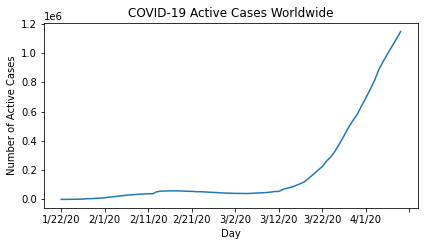

In [13]:
update_all_cases_country_individual()
update_all_cases_country()
worldwide_cases()
update_all_cases_country_active()
worldwide_active()

In [14]:
#Draft
def customCountries(list_countries):    
    for Country in list_countries:
        for data in dataset:
            country = data[0]
            country = country.pivot_table(index=['Country/Region'])
            country.columns = pd.to_datetime(country.columns)
            country = country.groupby(level=[0], sort=False).sum()
            country = country.loc[Country]
            country = country.sort_index().plot(label=data[1] + " in " + str(Country))
    
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + str(list(list_countries)))
    country.legend()

    #plt.savefig(str(list_countries) + ".png")
    
#customCountries(['China', 'US'])

# Visualizations with GeoPandas

Attempting to make visualizations using the longitude and latitude data from the dataset.

Goals:

1. Successfully implement GeoPandas and make it integrate with the database.

2. If all goes well, then make video, showing the growth of COVID-19


List of colors to associate
confirmed = red
deaths = black
recovered = green

https://geopandas.org/mapping.html

GeoPlot won't install... Not implementing for now...
https://geopandas.org/gallery/plotting_with_geoplot.html

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
#world['name'] = 'Australia'
#world['continent'] =

In [16]:
COVID19_geo_confirmed = pd.read_csv("COVID19_databases/time_series_covid19_confirmed_global.csv")
COVID19_geo_deaths = pd.read_csv("COVID19_databases/time_series_covid19_deaths_global.csv")
COVID19_geo_recovered = pd.read_csv("COVID19_databases/time_series_covid19_recovered_global.csv")

geo_dataset = [COVID19_geo_confirmed, COVID19_geo_deaths, COVID19_geo_recovered]

In [17]:
COVID19_geo_confirmed = COVID19_geo_confirmed.drop(['Lat', 'Long'], axis=1).pivot_table(index=['Country/Region'])
COVID19_geo_deaths = COVID19_geo_deaths.drop(['Lat', 'Long'], axis=1).pivot_table(index=['Country/Region'])
COVID19_geo_recovered = COVID19_geo_recovered.drop(['Lat', 'Long'], axis=1).pivot_table(index=['Country/Region'])

COVID19_geo_confirmed = COVID19_geo_confirmed.pivot_table(index=['Country/Region'])
COVID19_geo_deaths = COVID19_geo_deaths.pivot_table(index=['Country/Region'])
COVID19_geo_recovered = COVID19_geo_recovered.pivot_table(index=['Country/Region'])

COVID19_geo_confirmed = COVID19_geo_confirmed.groupby(level=[0], sort=False).sum()
COVID19_geo_deaths = COVID19_geo_deaths.groupby(level=[0], sort=False).sum()
COVID19_geo_recovered = COVID19_geo_recovered.groupby(level=[0], sort=False).sum()

COVID19_geo_confirmed.reset_index(level=0, inplace=True)
COVID19_geo_deaths.reset_index(level=0, inplace=True)
COVID19_geo_recovered.reset_index(level=0, inplace=True)

COVID19_geo_confirmed = COVID19_geo_confirmed.rename(columns={"Country/Region" : "name"})
COVID19_geo_deaths = COVID19_geo_deaths.rename(columns={"Country/Region" : "name"})
COVID19_geo_recovered = COVID19_geo_recovered.rename(columns={"Country/Region" : "name"})

In [18]:
COVID19_geo_confirmed = COVID19_geo_confirmed.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_deaths = COVID19_geo_deaths.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_recovered = COVID19_geo_recovered.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})

world_confirmed = world.merge(COVID19_geo_confirmed, how = 'inner', on = 'name')
world_confirmed = world_confirmed[(world_confirmed.pop_est>0) & (world_confirmed.name!="Antarctica")] #delete any islands and AntarticaCOVID19_geo_confirmed

world_deaths = world.merge(COVID19_geo_deaths, how = 'inner', on = 'name')
world_deaths = world_deaths[(world_deaths.pop_est>0) & (world_deaths.name!="Antarctica")] #delete any islands and AntarticaCOVID19_geo_confirmed

world_recovered = world.merge(COVID19_geo_recovered, how = 'inner', on = 'name')
world_recovered = world_recovered[(world_recovered.pop_est>0) & (world_recovered.name!="Antarctica")] #delete any islands and AntarticaCOVID19_geo_confirmed

In [19]:
def geo_confirmed_corona(data):
    dates = list(data)
    dates.remove('name')
    dates = [dt.datetime.strptime(date, '%m/%d/%y') for date in dates]
    dates.sort()
    dates = [dt.datetime.strftime(date, '%-m/%-d/%y') for date in dates]
    
    i = 0
    
    for date in dates:
        fig, ax = plt.subplots(1, 1)

        world_confirmed.plot(column=date,
                   cmap='OrRd',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})


        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_confirmed/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        i += 1
        
def geo_deaths_corona(data):
    dates = list(data)
    dates.remove('name')
    dates = [dt.datetime.strptime(date, '%m/%d/%y') for date in dates]
    dates.sort()
    dates = [dt.datetime.strftime(date, '%-m/%-d/%y') for date in dates]
    
    i = 0
    
    for date in dates:
        fig, ax = plt.subplots(1, 1)

        world_deaths.plot(column=date,
                   cmap='OrRd',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})


        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_deaths/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        i += 1
        
def geo_recovered_corona(data):
    dates = list(data)
    dates.remove('name')
    dates = [dt.datetime.strptime(date, '%m/%d/%y') for date in dates]
    dates.sort()
    dates = [dt.datetime.strftime(date, '%-m/%-d/%y') for date in dates]
    
    i = 0
    
    for date in dates:
        fig, ax = plt.subplots(1, 1)

        world_recovered.plot(column=date,
                   cmap='OrRd',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})


        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_recovered/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        i += 1
        
geo_confirmed_corona(COVID19_geo_confirmed)
geo_deaths_corona(COVID19_geo_deaths)
geo_recovered_corona(COVID19_geo_recovered)

In [20]:
def compile_timelapse():
    !rm geo/geo_confirmed/confirmed_timelapse.mp4
    !rm geo/geo_deaths/deaths_timelapse.mp4
    !rm geo/geo_recovered/recovered_timelapse.mp4
    
    !ffmpeg -r 2 -i geo/geo_confirmed/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_confirmed/confirmed_timelapse.mp4
    !ffmpeg -r 2 -i geo/geo_deaths/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_deaths/deaths_timelapse.mp4
    !ffmpeg -r 2 -i geo/geo_recovered/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_recovered/recovered_timelapse.mp4
        
compile_timelapse()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   